# Tutorial: Brd4 bindings for Male/Female mouses bulk callingcards data. 

These are brd4 bulk callingcards datasets in glioblastoma(GBM) in mouse brain of both female and male from [Kfoury et al., PNAS. (2021)](https://www.pnas.org/doi/10.1073/pnas.2017148118) and could be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156821).
 
 In this tutorial, we will call peaks, make annotation, do differential peak analysis, pair bindings with gene expression. There are 668525 insertions in female qbed data and 613728 insertions in male qbed data. For bulk RNA-seq data, there are 6 samples in total: 3 female samples and 3 male samples.

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading qbed data. In this data, one row is one insertion and columns indecate the chromosome, start point and end point, read number, direction and borcode of each insertion. For example, the first row means one insertion is in Chromosome 1 and starts from 3478112 to 3478115. The read number is 1 with direction from 3' to 5'. The barcode of the cell is TTTGTCCAA. We add another column as group. 

You could use ```cc.rd.read_qbed(filename)``` to load your own qbed data.

In [2]:
Female_Brd4 = cc.datasets.mouse_brd4_data(data="Female_Brd4")
Female_Brd4['group'] = "Female_Brd4"
Female_Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493702,3493706,1,+,CGTTACACA,Female_Brd4
...,...,...,...,...,...,...,...
1290214,chrY,90802841,90802845,1,-,CGTTACACA,Female_Brd4
1290215,chrY,90803579,90803583,1,-,TATGTACAA,Female_Brd4
1290216,chrY,90803579,90803583,1,-,TGTCGTGCA,Female_Brd4
1290217,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4


In [3]:
Male_Brd4 = cc.datasets.mouse_brd4_data(data="Male_Brd4")
Male_Brd4['group'] = "Male_Brd4"
Male_Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
1,chr1,3493275,3493279,1,+,TACTTTCCG,Male_Brd4
2,chr1,3493341,3493345,2,+,AGCACAGTG,Male_Brd4
3,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
4,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
...,...,...,...,...,...,...,...
1185697,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
1185698,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
1185699,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
1185700,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4


Combine the two data to call peaks together.

In [4]:
Brd4 = cc.rd.combine_qbed([Female_Brd4,Male_Brd4])
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
...,...,...,...,...,...,...,...
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
2475917,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4
2475918,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4
2475919,chrY,90805130,90805134,1,-,GACGGCTCC,Female_Brd4


Filter the insertions with reads larger than 2.

In [5]:
Brd4 = Brd4[Brd4['Reads']>2]
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
7,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
8,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
10,chr1,3493643,3493647,3,+,TCTACTGCC,Male_Brd4
17,chr1,3514553,3514557,7,+,TACTTTCCG,Male_Brd4
...,...,...,...,...,...,...,...
2475905,chrY,42512546,42512550,3,-,ACGCGCTGT,Male_Brd4
2475914,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
2475915,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4


Because insertions are discrete, we now call peaks to deduce potential binding sites. Three different methods (*CCcaller,cc_tools,Blockify*) are available along with there different species (*hg38,mm10,yeast*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*, it would control the maximum distance bwtween two nearby insertions, in another word, that is the minimun distance between two peaks. 800-2500 is a good parameter for *maxbetween*.  *pvalue_cutoff* is also an important parameter and a number below 0.05 is strongly advised.

In [6]:
peak_data = cc.pp.callpeaks(Brd4, method = "CCcaller", reference = "mm10", pvalue_cutoff = 0.01, maxbetween = 1100,
                   lam_win_size = 1000000,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06
...,...,...,...,...,...,...,...
27656,chrX,169950414,169952152,7,15,2.179246,1.866302e-03
27657,chrY,897430,899700,11,24,0.528165,6.046275e-13
27658,chrY,1009018,1011799,27,25,0.489073,0.000000e+00
27659,chrY,1243715,1246316,24,29,0.504932,0.000000e+00


In [7]:
peak_data = cc.pp.callpeaks(Brd4, method = "CCcaller", reference = "mm10", pvalue_cutoff = 0.01, maxbetween = 1100,
                   lam_win_size = 1000000,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06
...,...,...,...,...,...,...,...
27656,chrX,169950414,169952152,7,15,2.179246,1.866302e-03
27657,chrY,897430,899700,11,24,0.528165,6.046275e-13
27658,chrY,1009018,1011799,27,25,0.489073,0.000000e+00
27659,chrY,1243715,1246316,24,29,0.504932,0.000000e+00



In order to choose suitable method and parameters for peak calling, please take a look at genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the first part is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The second part is the distribution of insertions. The third part represents reference genes and peaks. 

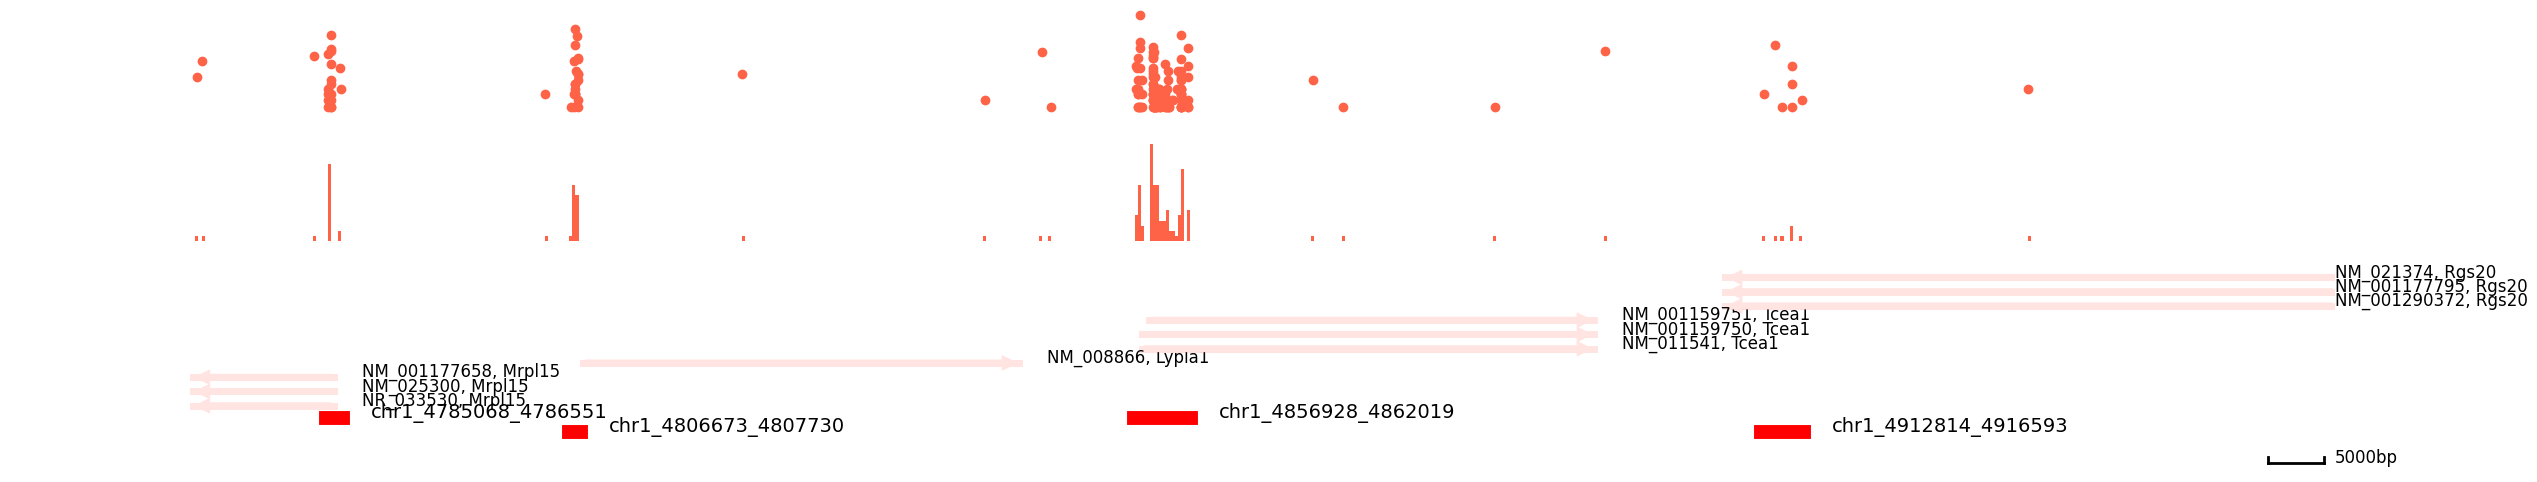

In [8]:
cc.pl.draw_area("chr1",4856929,4863861,100000,peak_data, Brd4, "mm10", 
                figsize = (30,6),peak_line = 2,save = False, example_length = 5000)

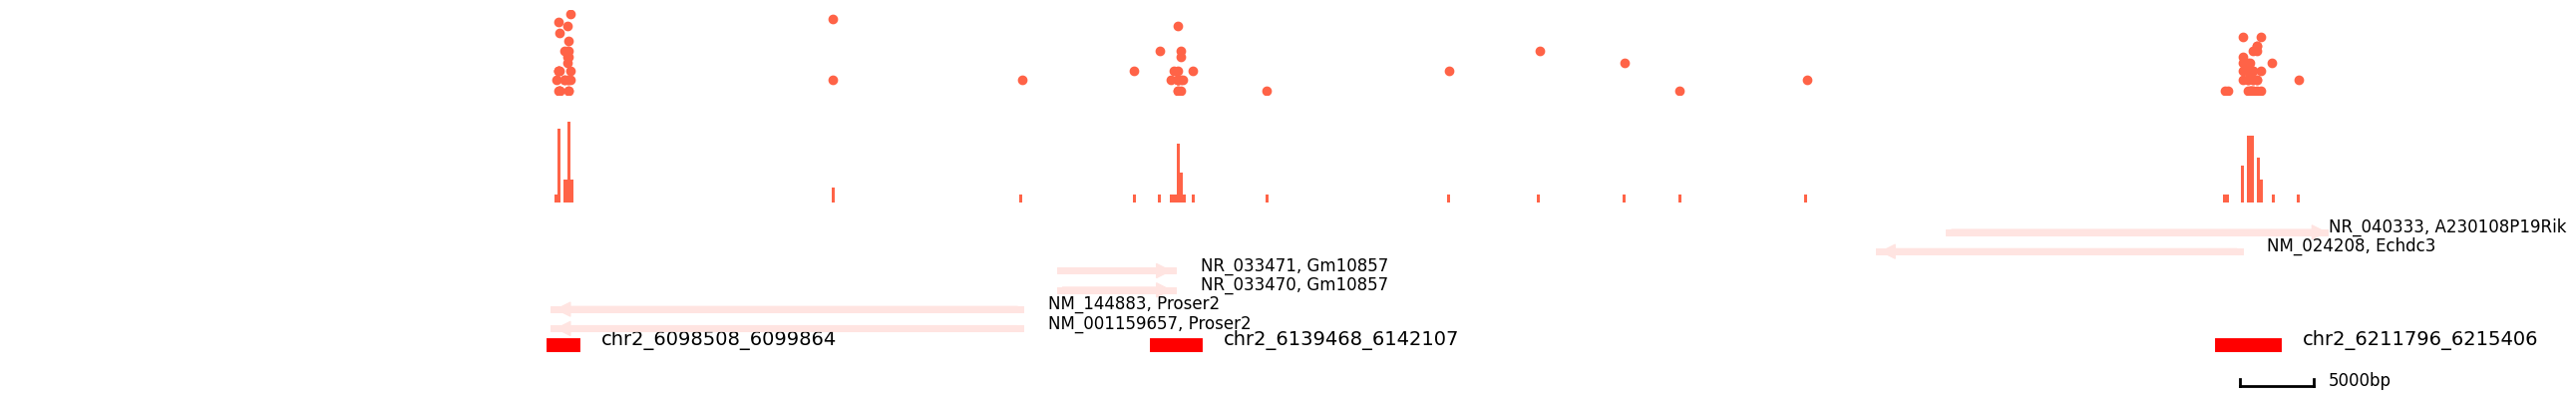

In [9]:
cc.pl.draw_area("chr2",6136575,6144043,75000, peak_data, Brd4, "mm10", 
                figsize = (30,5),peak_line = 1,save = False, example_length = 5000)

We could also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only valid for 24h, please rerun it if you want to use it.

In [10]:
qbed = {"Brd4":Brd4}
bed = {"peak":peak_data}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/9b107de5e0a93db83e26454c4d95ccd0/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going right.

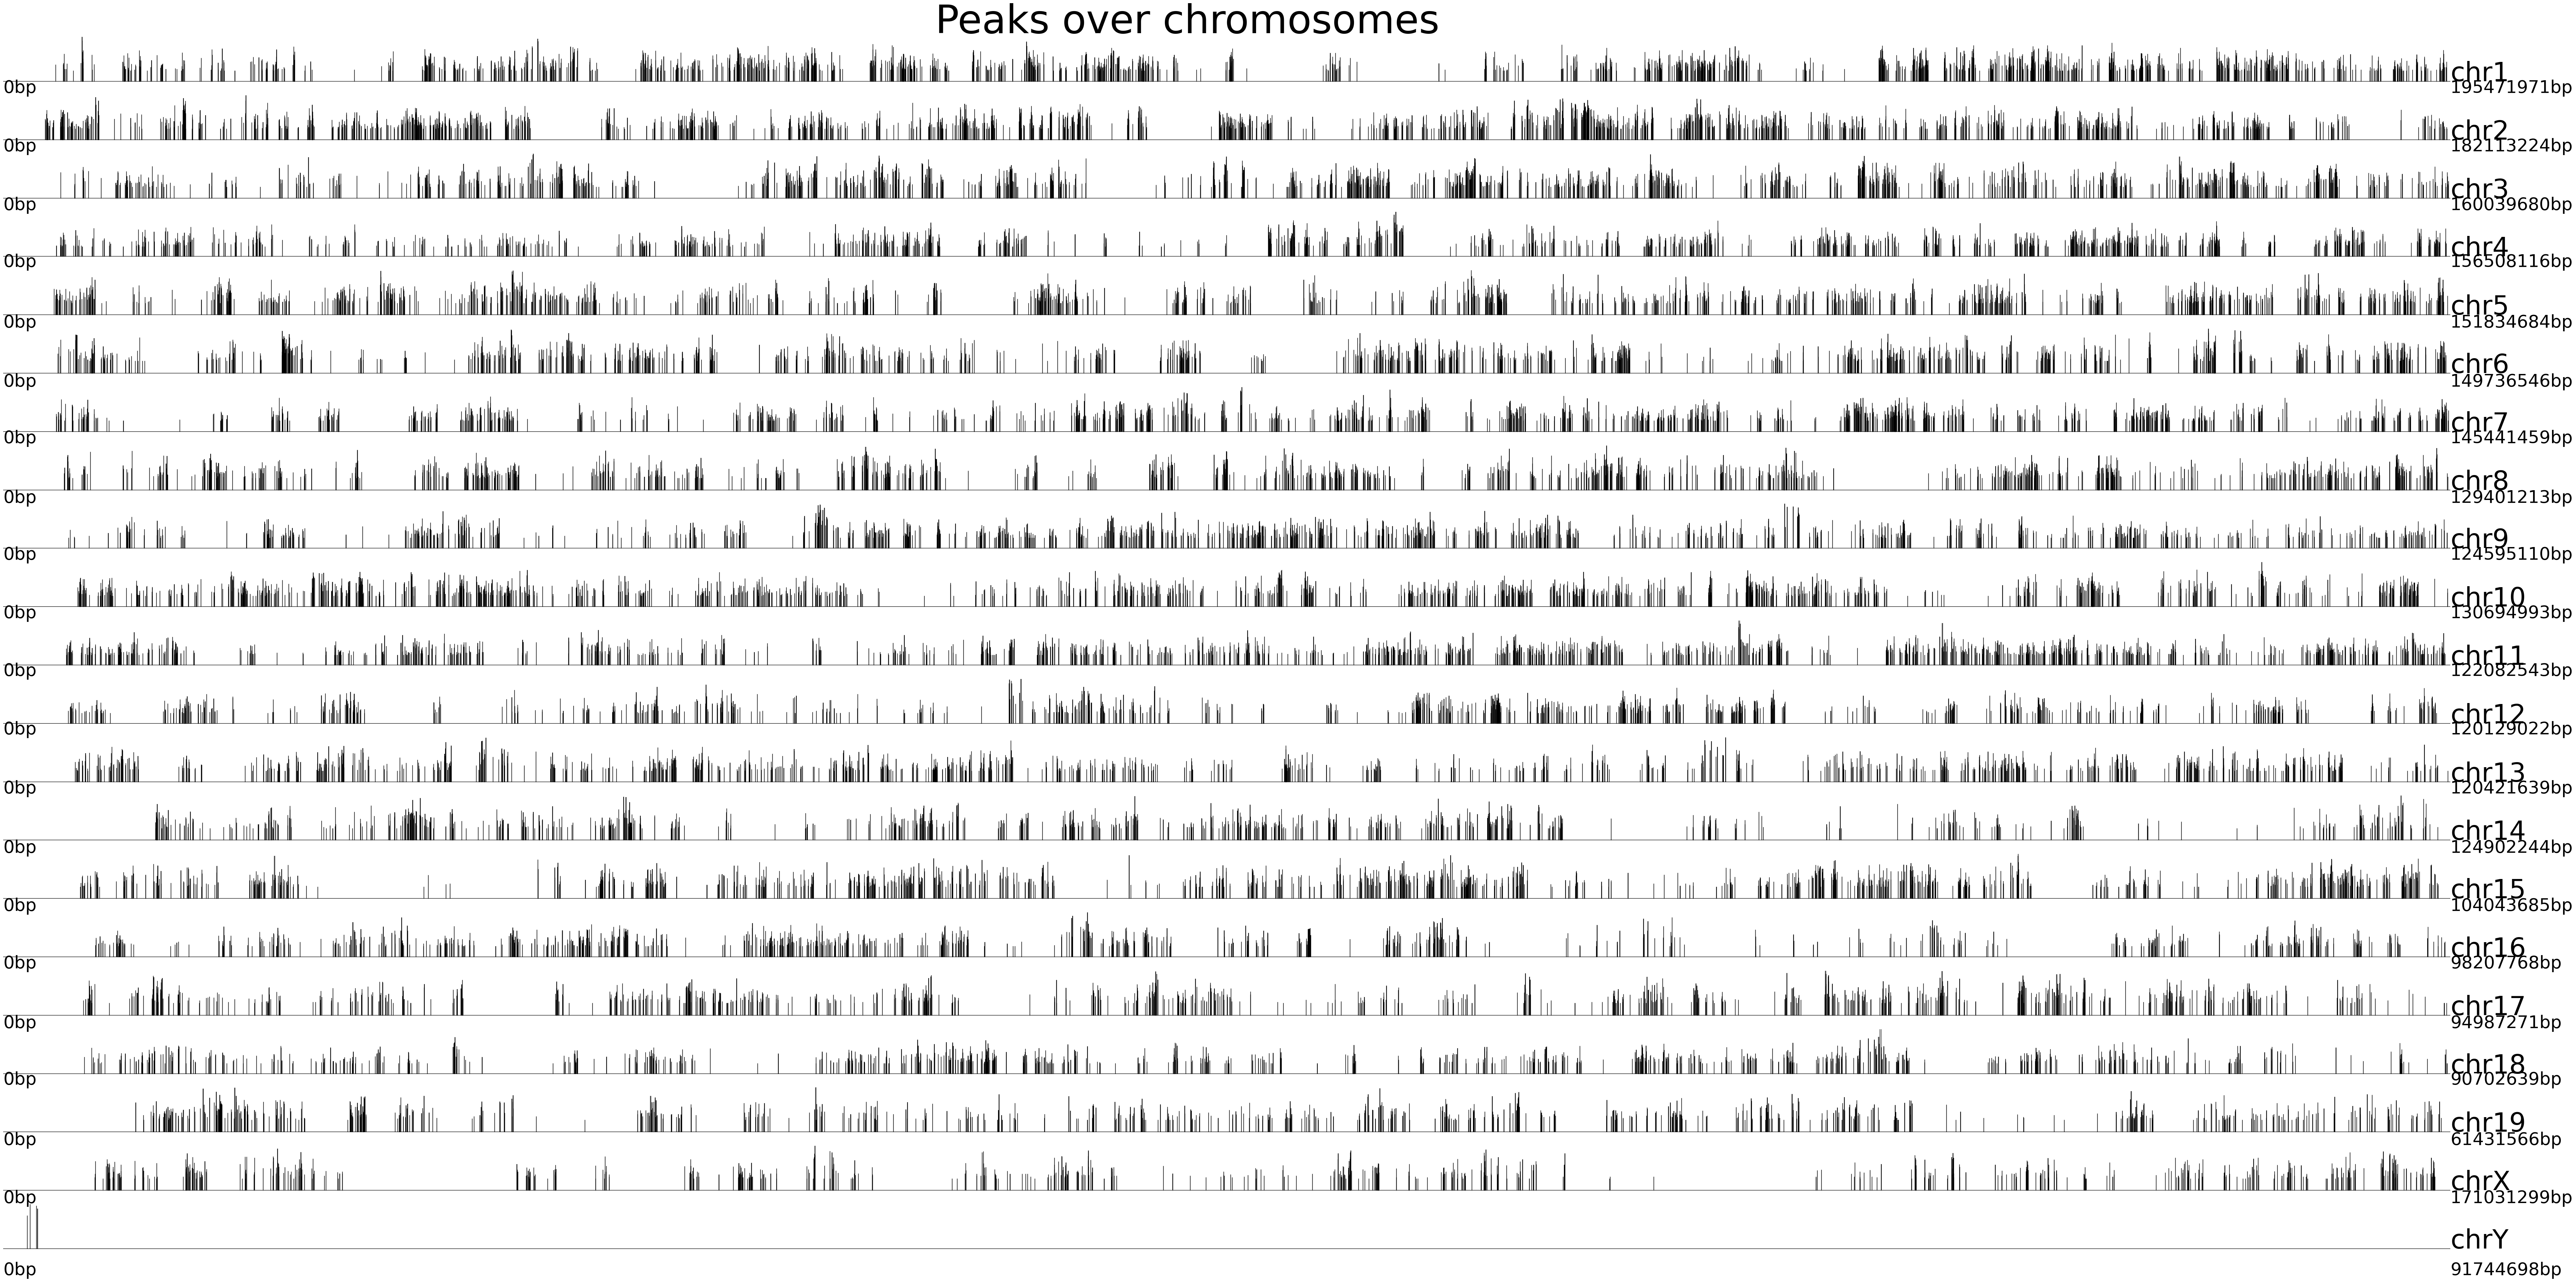

In [11]:
cc.pl.whole_peaks(peak_data, reference = "mm10", linewidth = 1)

Here, we first combine the data and then call peaks together. Although not recommended, you could also try calling peaks seperately and then merge the peaks by [pybedtools](https://daler.github.io/pybedtools/). Below are the codes:

```python
import pybedtools
peak_data1 = cc.pp.callpeaks(Female_Brd4,  method = "CCcaller", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 2000,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.callpeaks(Male_Brd4,  method = "CCcaller", reference = "mm10",  pvalue_cutoffbg = 0.1, maxbetween = 2000,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak = cc.rd.combine_qbed([peak_data1,peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
```

In the next step, we find out the closest genes for each peak to annotate using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [12]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00,NM_001195662,Rp1,NM_011283,Rp1
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00,NR_033530,Mrpl15,NM_008866,Lypla1
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00,NM_008866,Lypla1,NR_033530,Mrpl15
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00,NM_011541,Tcea1,NM_008866,Lypla1
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06,NM_001290372,Rgs20,NM_011541,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...
27656,chrX,169950414,169952152,7,15,2.179246,1.866302e-03,NM_010797,Mid1,NR_029457,G530011O06Rik
27657,chrY,897430,899700,11,24,0.528165,6.046275e-13,NM_011419,Kdm5d,NM_011667,Uba1y
27658,chrY,1009018,1011799,27,25,0.489073,0.000000e+00,NM_012011,Eif2s3y,NR_027507,Tspy-ps
27659,chrY,1243715,1246316,24,29,0.504932,0.000000e+00,NM_009484,Uty,NM_012008,Ddx3y


Use qbed data, peak data and barcode data to make a cell by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.

In [13]:
adata_cc = cc.pp.makeAnndata(Brd4, peak_annotation, ["Female_Brd4","Male_Brd4"], key = 'group')
adata_cc

100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


AnnData object with n_obs × n_vars = 2 × 27661
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [14]:
adata_cc.obs

""
Index
Female_Brd4
Male_Brd4


Differential peak analysis would find out the significant binding for each group. In this example, we use *fisher exact test* to find out.

In [15]:
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact')

100%|██████████| 2/2 [02:15<00:00, 67.53s/it]


Plot the results for differential peak analysis.

```python
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

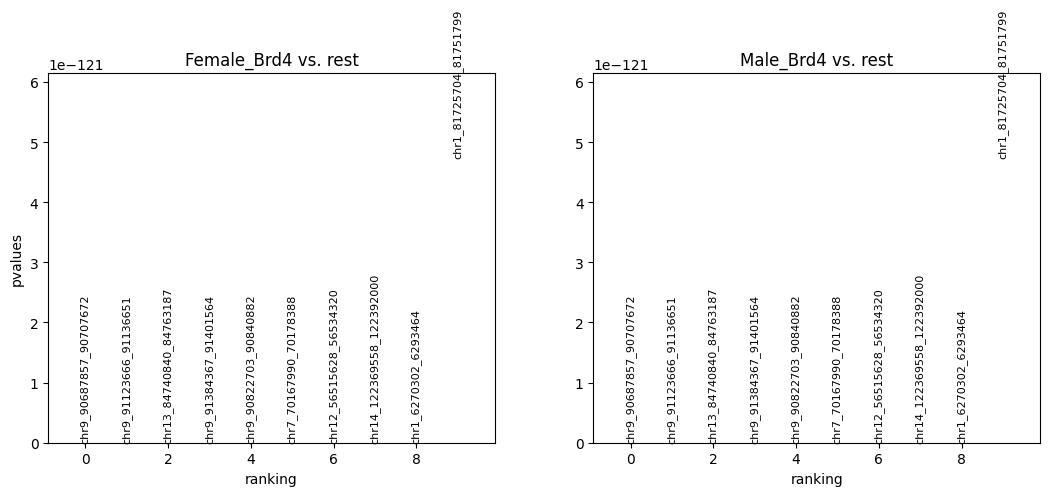

In [16]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact', rankby = 'pvalues')

Then, we take a look at the genome for the highly differentiated peaks. The colored ones are the insertions for specific cluster and the grey ones are the total insertions for the whole dataset. 

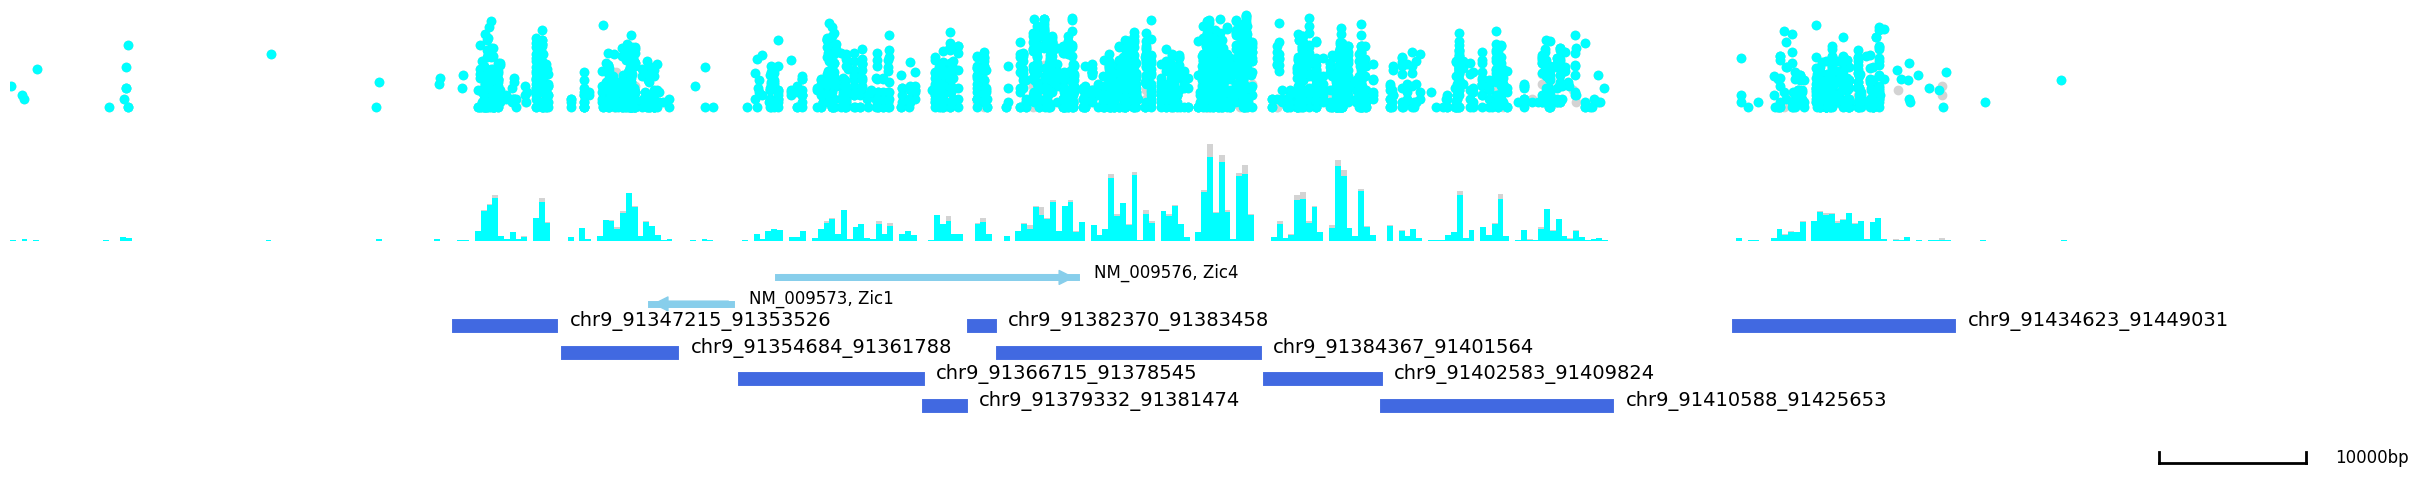

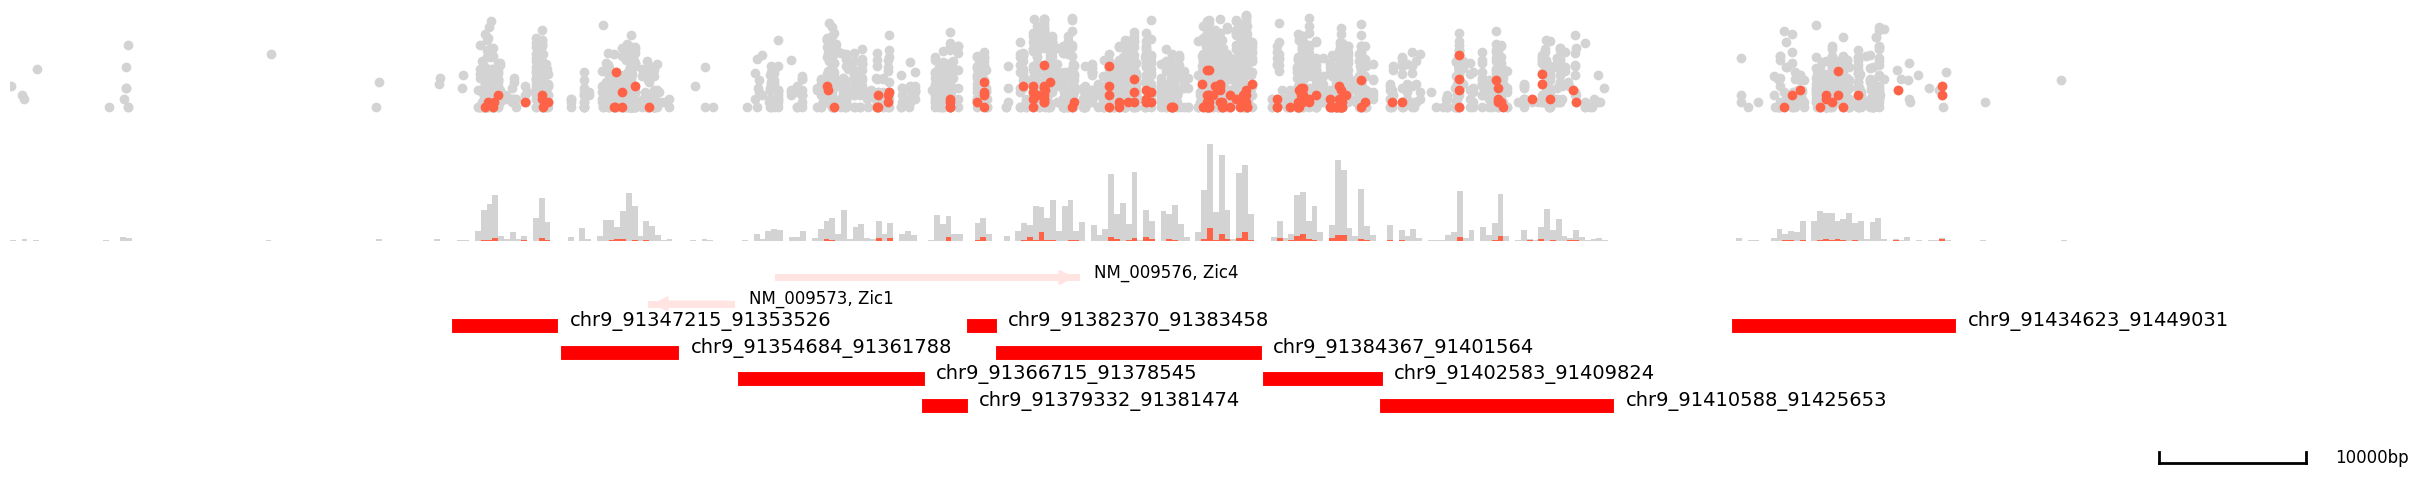

In [17]:
cc.pl.draw_area("chr9",91366534,91425373,50000,peak_data,Brd4,"mm10",adata = adata_cc, 
                name = "Female_Brd4",key = "Index",insertionkey = "group", bins = 400, figsize = (30,6), peak_line = 4,color = "blue")
cc.pl.draw_area("chr9",91366534,91425373,50000,peak_data, Brd4,"mm10",adata = adata_cc, 
                name = "Male_Brd4",key = "Index", insertionkey = "group",bins = 400, figsize = (30,6),peak_line = 4)

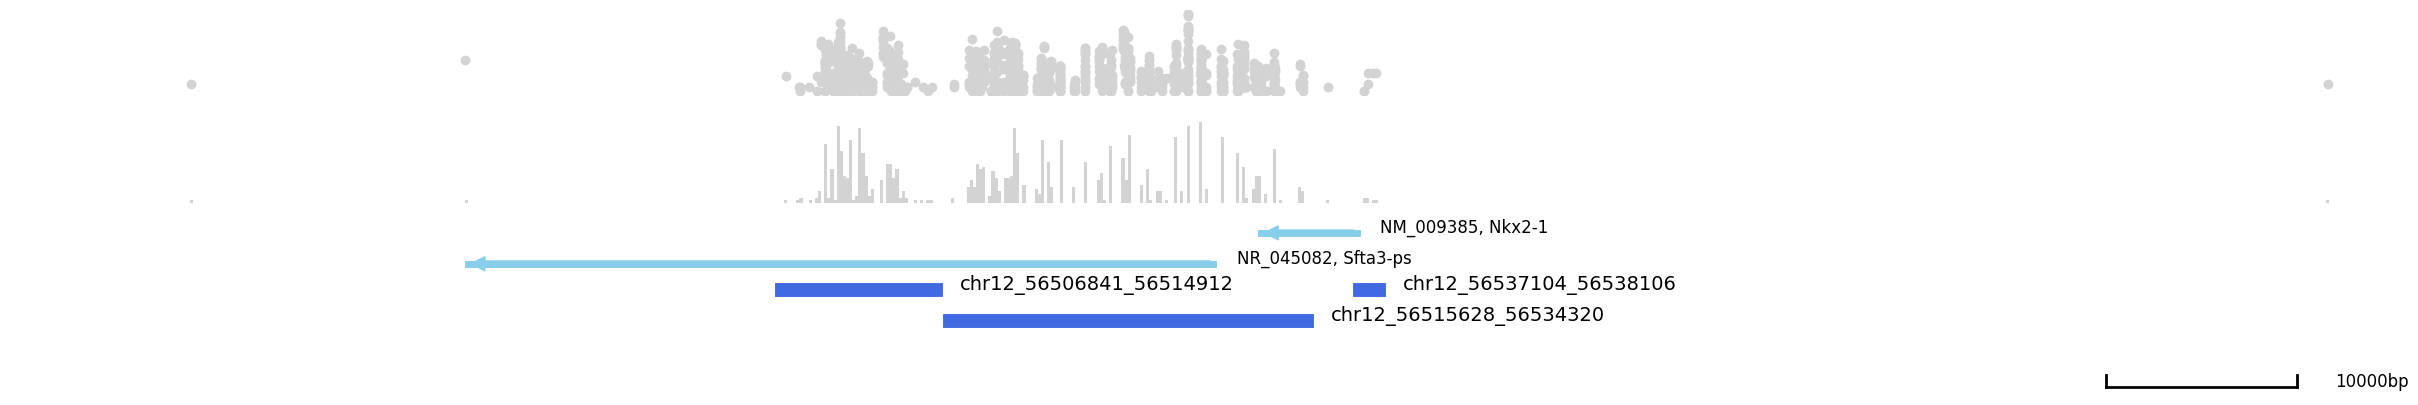

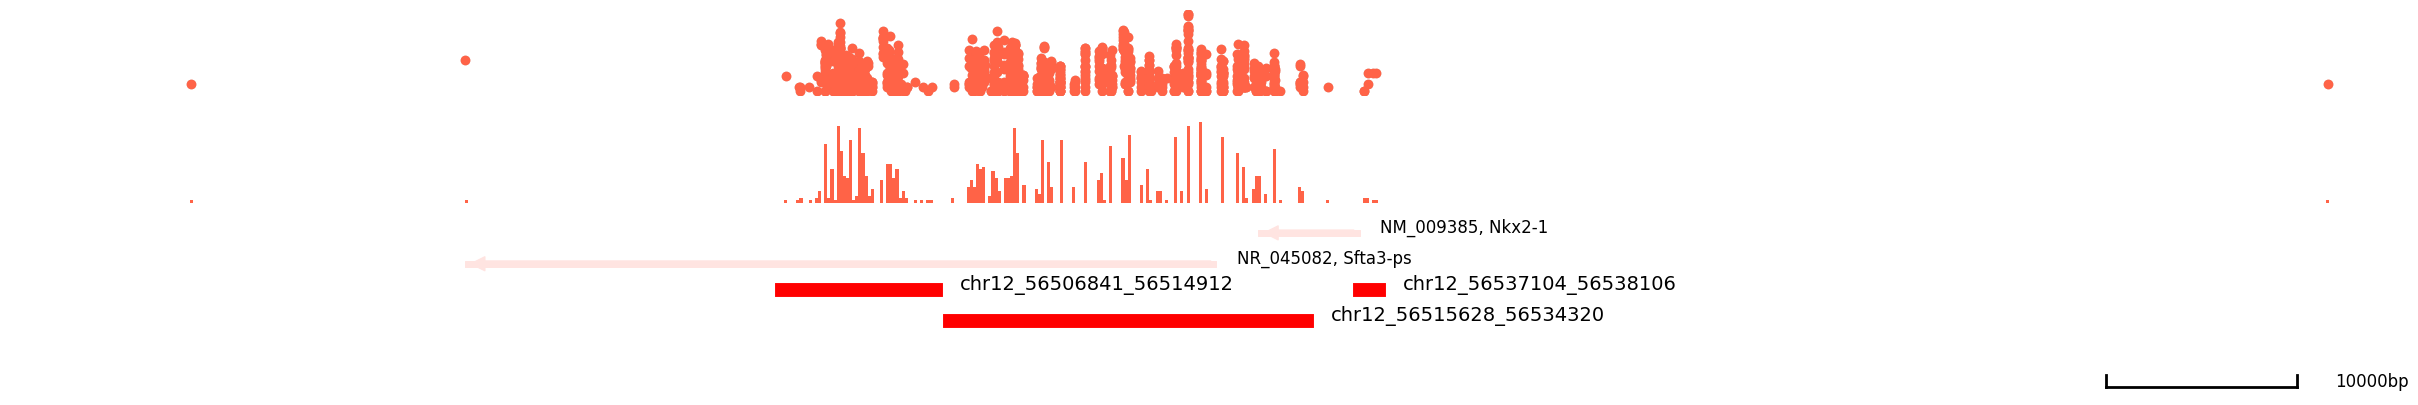

In [18]:
cc.pl.draw_area("chr12",56516453,56538107,50000,peak_data,Brd4,"mm10",adata = adata_cc, 
                name = "Female_Brd4",key = "Index",insertionkey = "group", figsize = (30,5),peak_line = 2,color = "blue")
cc.pl.draw_area("chr12",56516453,56538107,50000,peak_data, Brd4,"mm10",adata = adata_cc, 
                name = "Male_Brd4",key = "Index", insertionkey = "group", figsize = (30,5),peak_line = 2)

Plot the volcano plot for differential binding sites. labelright and labellest are the location points of the labels.

/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_volcano.py:59: RuntimeWarning: divide by zero encountered in log10
  pva = -np.log10(np.array(adata_cc.uns["fisher_exact"]["pvalues"].tolist())[:, 1])


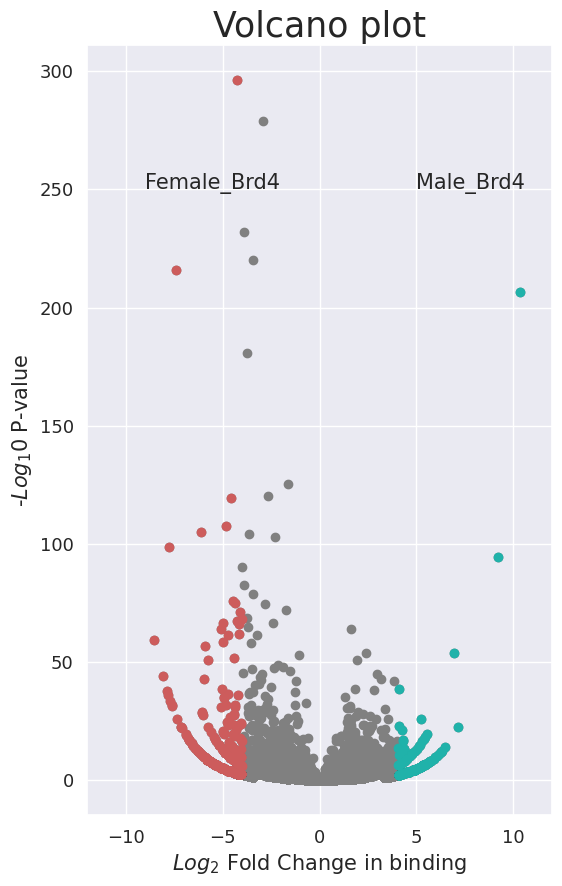

In [19]:
cc.pl.volcano_plot(adata_cc,figsize = (6,10),labelright = (5,250),labelleft = (-9,250))

Read bulk RNA-seq data. Note that this RNA-seq data is normalized by [RPKM](https://wiki.arrayserver.com/wiki/index.php?title=RPKM).

In [20]:
rna =  cc.datasets.mouse_brd4_data(data="RNA")
rna

,sample.f6_dmso_3,sample.f6_dmso_2,sample.f6_dmso_1,sample.m6_dmso_3,sample.m6_dmso_2,sample.m6_dmso_1
mt-Tf,0.000000,0.639272,0.000000,1.156308,0.000000,0.687531
mt-Rnr1,127.907281,184.396768,172.544723,130.417054,192.566581,114.212201
mt-Tv,0.000000,0.000000,1.761150,0.000000,0.510777,0.000000
mt-Rnr2,247.267306,527.855824,324.345998,675.031187,684.376279,418.345603
mt-Tl1,44.418710,117.660098,70.481211,167.217607,115.129081,127.789076
...,...,...,...,...,...,...
Gm16897,0.281553,0.349020,0.463442,0.078913,0.070742,0.112610
A330023F24Rik,0.118678,0.055749,0.058441,0.029411,0.018833,0.049965
Cd46,0.127930,0.095151,0.075997,0.061467,0.055103,0.087715
Cr1l,9.993119,14.027801,13.717564,13.586101,13.240219,11.089902


Plot heatmap for calling cards data and gene expression data. 

The top lines are the relative binding expression for the two groups. The buttom lines are the gene expression of the top two nearest genes separately. 

We could see a relationship between bindings and gene expression. Bindings tend to have possitive effects for gene expression and have stronger effects for the nearest one than the second nearest one.

Please make sure that the samples in adata_cc and rna are in the same order.


/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:130: RuntimeWarning: invalid value encountered in divide
  data[groupnumber:secondnum, :]
/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:132: RuntimeWarning: invalid value encountered in divide
  data[secondnum:, :]


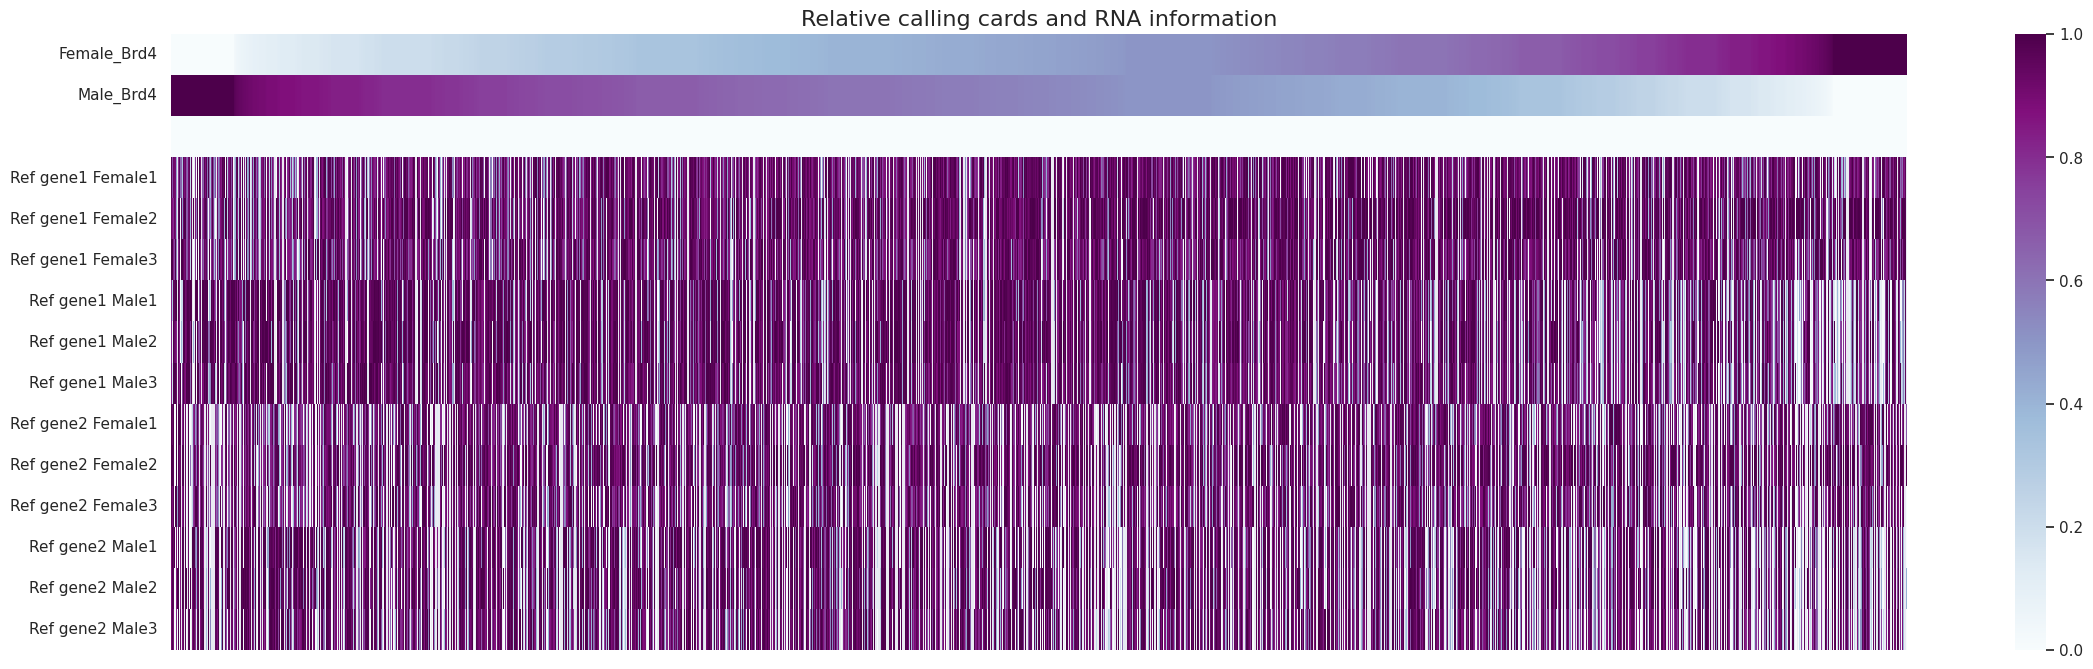

In [21]:
cc.pl.heatmap(adata_cc,rna, rnalabels = ["Female1", "Female2", "Female3","Male1", "Male2","Male3"])

Find out the co-differential peak-gene pairs. It would look into all the differential peaks and then see if the annotated genes are also significant expressed. We could set the pvalue and score/log foldchange cutoff easily.

In [22]:
result = cc.tl.pair_peak_gene_bulk(adata_cc,"https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/deseq_MF.csv",name_cc = 'logfoldchanges',
                                   pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, lfc_cutoff_rna = 5, lfc_cutoff_cc = 5)
result

,Peak,logfoldchanges_peak,Pvalue_peak,Gene,Score_gene,Pvalue_peak
0,chr1_174659622_174662521,5.620740,1.523830e-08,Grem2,-10.401831,1.280025e-67
1,chr1_174917639_174921559,6.176796,2.695571e-12,Grem2,-10.401831,1.280025e-67
2,chr2_93645657_93648162,5.158166,2.353647e-06,Alx4,-10.292504,5.458739e-18
3,chr3_33140350_33142508,5.502993,6.431489e-08,Pex5l,-7.590236,2.351122e-24
4,chr3_126498429_126499612,5.306123,5.576616e-07,Arsj,-6.281259,8.667831e-27
5,chr3_126657669_126660188,-5.365740,5.555771e-07,Arsj,-6.281259,8.667831e-27
6,chr3_132085669_132092999,6.118516,1.425832e-105,Dkk2,-6.916087,9.389039e-178
7,chr3_132093815_132106295,5.070511,9.279848e-65,Dkk2,-6.916087,9.389039e-178
8,chr3_141699368_141702608,6.054683,2.366213e-29,Bmpr1b,-5.570116,6.893076e-40
9,chr4_68535893_68538867,5.161834,1.965019e-15,Brinp1,-7.758307,5.384595e-10


Plot the above results.

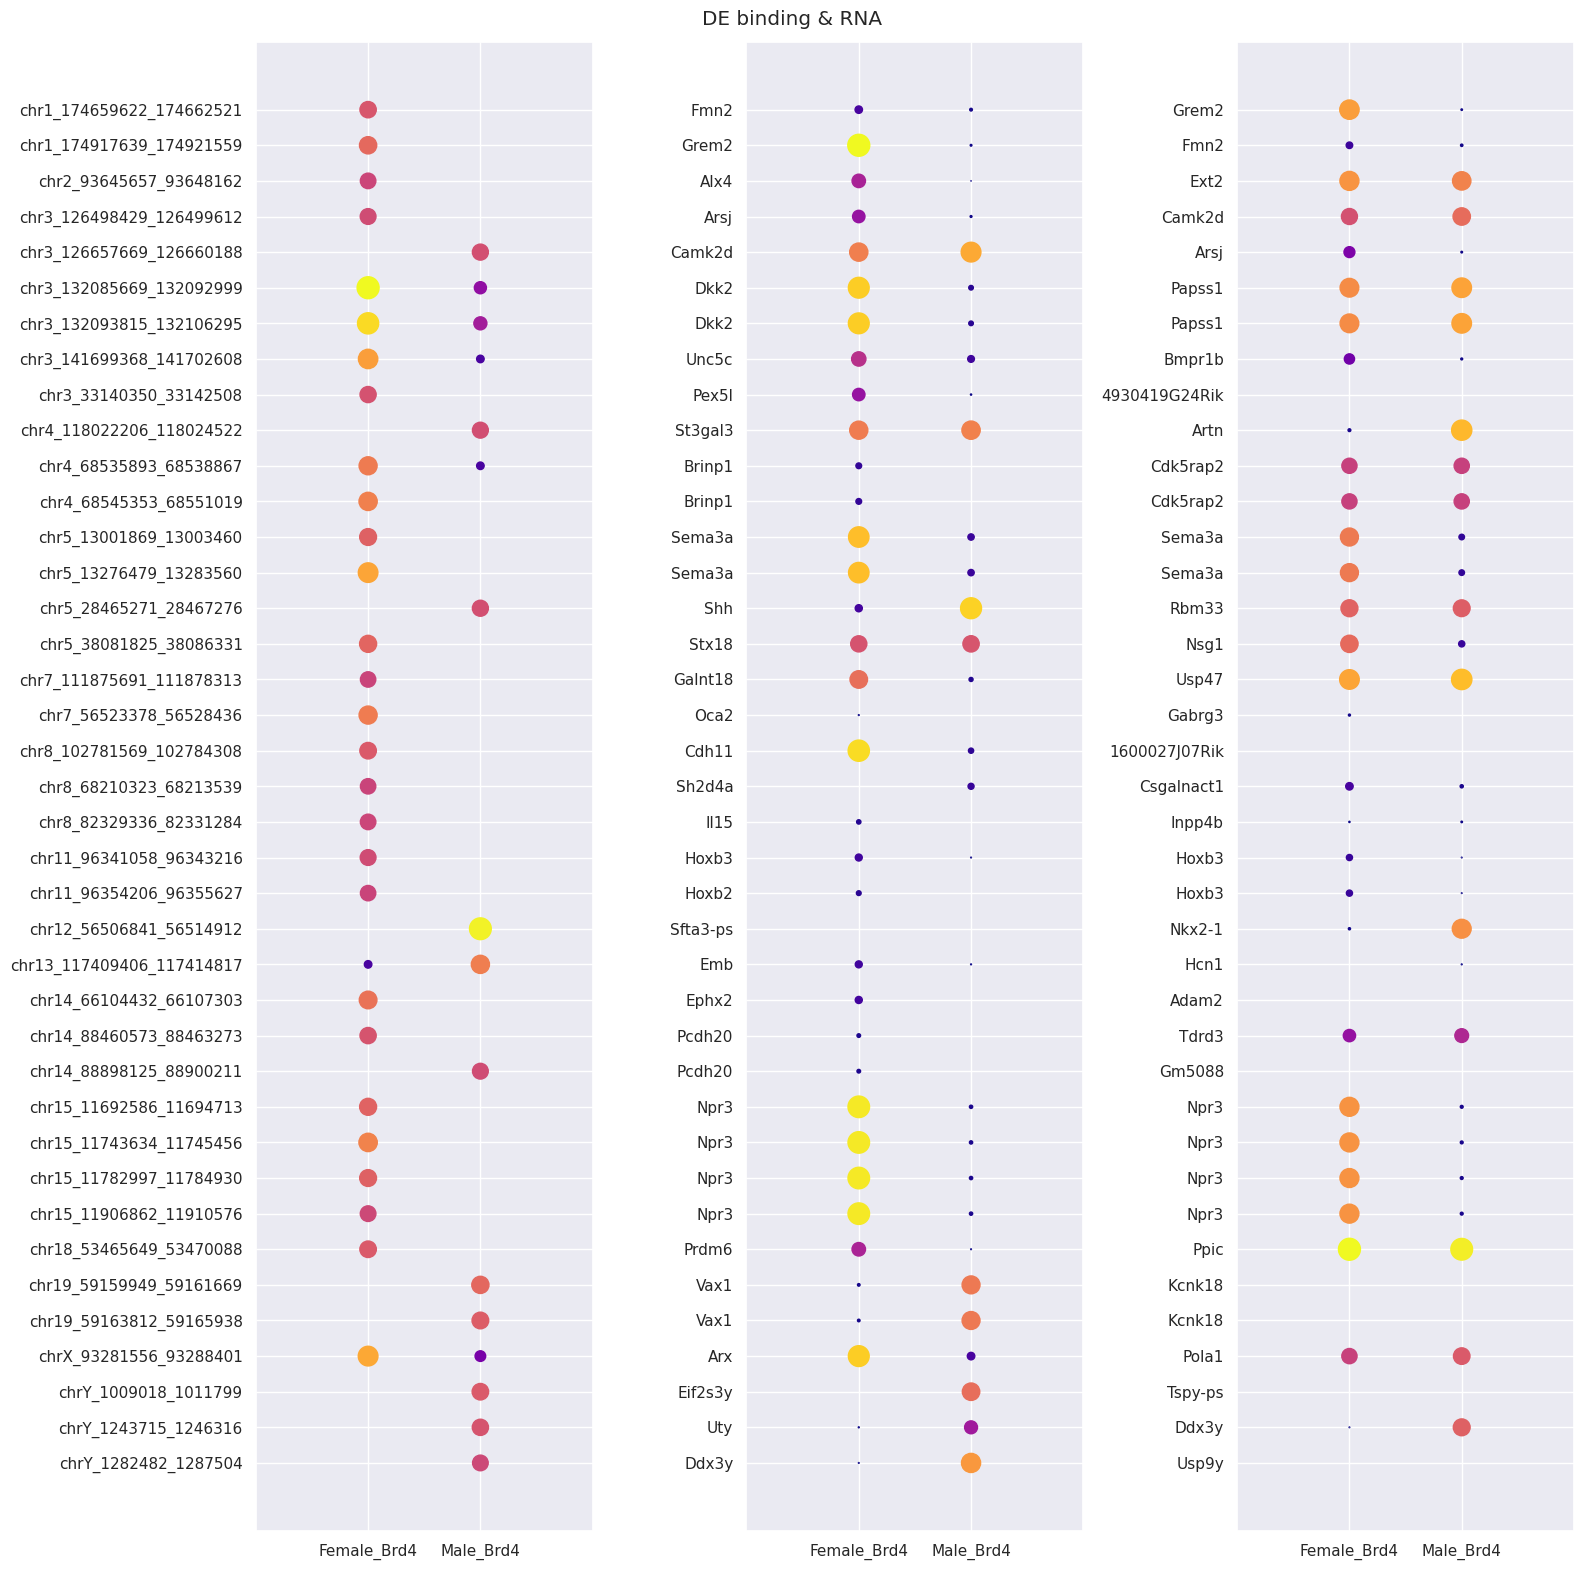

In [23]:
cc.pl.dotplot_bulk(adata_cc,rna,selected_list = list(np.unique(np.array(result["Peak"]))), num_list = [3,3], cmap = 'plasma', figsize=(16, 16), sort_by_chrom = True, topspace=0.96)

We could see from the results that all bindings are differential and at least one of the nearest genes is differeintial. For most of the situations, bindings have a positive influence on gene expression. We could make many hypotheses to test.

Save the file if needed.

In [24]:
adata_cc.write("Brd4_bindings_bulk.h5ad")